In [34]:
# !pip install xgboost
# !pip install graphviz
# import sys
# sys.path.append("/Users/apple/.pyenv/versions/3.5.4/lib/python3.5/site-packages/graphviz")


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import cross_validate,cross_val_score
import xgboost
import seaborn as sns

### Since we have a lot of missing values and outliers, it is preferable to start with xgboost. 
### XGboost algorithm is invariant to outliers and can handle missing values by default
### so first strategy is replacing any wrong/missing value by null, build the model and check the accuracy
### based on the accuracy and model evaluation, it will be very clear which direction is better to take(differect imputation technique, deal with bias/variance of the model, ...)

## First LOad all columns to test their contribution to model accurecy to select best features based on model accurracy and analysis in exploration file 

In [36]:
colsToLoad =["INSTNM","CONTROL","ADM_RATE","ADM_RATE_ALL","ACTCMMID","ACTENMID","ACTMTMID","ACTWRMID","SAT_AVG","SAT_AVG_ALL","SATMTMID","UGDS","HIGHDEG",  "TUITFTE",  "COSTT4_P",
             "COSTT4_A", "PCTFLOAN","COMP_ORIG_YR2_RT", "UGDS_WHITE","UGDS_BLACK","UGDS_HISP","UGDS_ASIAN","UGDS_AIAN","UGDS_NHPI","UGDS_2MOR","UGDS_NRA","UGDS_UNKN","PPTUG_EF","TUITIONFEE_IN","TUITIONFEE_OUT","TUITIONFEE_PROG","INEXPFTE","AVGFACSAL","PCTPELL","DEATH_YR3_RT","COMP_ORIG_YR3_RT","LOAN_DEATH_YR3_RT","LOAN_COMP_ORIG_YR3_RT","DEATH_YR4_RT","COMP_ORIG_YR4_RT","AGE_ENTRY","COUNT_NWNE_P10","COUNT_WNE_P10","MN_EARN_WNE_P10","MD_EARN_WNE_P10","COMPL_RPY_1YR_RT"]
scoreCardDF = pd.read_csv("../data/CollegeScorecard_Raw_Data/MERGED2013_14_PP.csv", index_col="INSTNM",usecols=colsToLoad)

/Users/apple/.pyenv/versions/3.5.4/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1606) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
colsToLoad.sort()
colsToLoad

['ACTCMMID',
 'ACTENMID',
 'ACTMTMID',
 'ACTWRMID',
 'ADM_RATE',
 'ADM_RATE_ALL',
 'AGE_ENTRY',
 'AVGFACSAL',
 'COMPL_RPY_1YR_RT',
 'COMP_ORIG_YR2_RT',
 'COMP_ORIG_YR3_RT',
 'COMP_ORIG_YR4_RT',
 'CONTROL',
 'COSTT4_A',
 'COSTT4_P',
 'COUNT_NWNE_P10',
 'COUNT_WNE_P10',
 'DEATH_YR3_RT',
 'DEATH_YR4_RT',
 'HIGHDEG',
 'INEXPFTE',
 'INSTNM',
 'LOAN_COMP_ORIG_YR3_RT',
 'LOAN_DEATH_YR3_RT',
 'MD_EARN_WNE_P10',
 'MN_EARN_WNE_P10',
 'PCTFLOAN',
 'PCTPELL',
 'PPTUG_EF',
 'SATMTMID',
 'SAT_AVG',
 'SAT_AVG_ALL',
 'TUITFTE',
 'TUITIONFEE_IN',
 'TUITIONFEE_OUT',
 'TUITIONFEE_PROG',
 'UGDS',
 'UGDS_2MOR',
 'UGDS_AIAN',
 'UGDS_ASIAN',
 'UGDS_BLACK',
 'UGDS_HISP',
 'UGDS_NHPI',
 'UGDS_NRA',
 'UGDS_UNKN',
 'UGDS_WHITE']

## drop all rows that do not have a value for out target variable

In [38]:
scoreCardDF =scoreCardDF[(scoreCardDF["COMPL_RPY_1YR_RT"] != "PrivacySuppressed") & (scoreCardDF["COMPL_RPY_1YR_RT"] != np.nan)  & (scoreCardDF["COMPL_RPY_1YR_RT"] != None) &(scoreCardDF["COMPL_RPY_1YR_RT"].notna())]


## Now lets drop un-needed columns for input features
### COMPL_RPY_1YR_RT is the target
### INSTNM is the index but not needed in regression analysis
### float_columns: float columns of type float will be treated differently in preprocessing 
### cat_columns : category columns of type float will be treated differently in preprocessing

In [39]:
# all features without the target & 
input_features =  [f for f in colsToLoad if f not in ["INSTNM","COMPL_RPY_1YR_RT"]] 
cat_columns = ["HIGHDEG","CONTROL"]
float_columns = [f for f in input_features if f not in cat_columns]
target_feature = "COMPL_RPY_1YR_RT"

## Coming Cells are responsible for the preprocessing of float and cat columns

In [40]:
# this function is designed to convert PrivacySuppressed value in any input column to null.
# this is because our first strategy is keeping missing values, and let xgboot handle this situation
def cleanPrivacySuppressed(dataFrame):
    for colName in dataFrame.columns:
        dataFrame[colName] =  dataFrame[colName].replace("PrivacySuppressed", np.nan)
        dataFrame[colName] = dataFrame[colName].astype(float)
    return dataFrame 

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
class PrivacySuppressedHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  
    def transform(self, X, y=None):
        return cleanPrivacySuppressed(X)
  

In [42]:
# pipe line for all float columns
# it is a separate pipe line, because there is a potential to add more preprocessing steps based on model evaluation
float_pipeline = ColumnTransformer([
         ("privacy_suppressed_hnadler", PrivacySuppressedHandler(),float_columns),   
 
    ])

# pipe line for all Category columns
cat_pipeline = ColumnTransformer([
         ("hot_encoder",OneHotEncoder(),cat_columns)
    ])


## Biulding the whole pipline of preprocessing

In [43]:

from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(
    transformer_list=[ 
        ("float_pipeline", float_pipeline),
        ("cat_pipeline", cat_pipeline)
])

In [44]:
processed_input_features = full_pipeline.fit_transform(scoreCardDF)
target_output = scoreCardDF[target_feature]

## Now we will split ou db to train, validate (80/20)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(processed_input_features, target_output.values ,test_size=0.2)

## Building Xgboost with default values, the chosen error function is squared_error
## beacause we are very sesetive to higher errors

In [46]:
model = xgboost.XGBRegressor(seed=42,objective="reg:squarederror") 


In [47]:
# fit the model
model.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=1, verbosity=1)

In [48]:
# mesure the accuracy of validation set
prediction = model.predict(X_val)

## Now lets measure the model accuracy on validation set

In [1]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_val, prediction)

## Now lets measure the model accuracy on Train set

In [50]:
mean_squared_error(Y_train, model.predict(X_train))

0.0055507453464764675

## Now lets measure r squared error on validation set, to know how good is the fit

In [51]:
from sklearn.metrics import r2_score
r2_score(Y_val, prediction)

0.8115581329960441

## Now lets measure r squared error on train set

In [52]:
r2_score(Y_train, model.predict(X_train))

0.857800426135847

# from results above, it seems xgboost is a potential for a good model but there is some overfitting because error in validation is higher and r squared is less

# Now, Evaluation using cross validation

In [53]:

from sklearn.model_selection import cross_validate,cross_val_score



# Evaluation Using root mean squared error

In [54]:
cross_val_score(model,processed_input_features,target_output.values,cv=10,scoring='neg_root_mean_squared_error')

array([-0.09507048, -0.09569047, -0.08928754, -0.08017776, -0.08517201,
       -0.07963659, -0.09305667, -0.09121318, -0.08619059, -0.12119776])

In [55]:
cross_val_score(model,processed_input_features,target_output.values,cv=3,scoring='neg_root_mean_squared_error')

array([-0.09248456, -0.08509294, -0.10533189])

# Evaluation Using r squared

In [56]:
cross_val_score(model,processed_input_features,target_output.values,cv=10,scoring='r2')

array([0.72365996, 0.72619765, 0.76113909, 0.80292646, 0.82425461,
       0.82516832, 0.64431851, 0.59958678, 0.60560288, 0.33529425])

In [57]:
cross_val_score(model,processed_input_features,target_output.values,cv=3,scoring='r2')

array([0.75106527, 0.82043188, 0.47892856])

# it seems there are some data points that make probleme when added (last set of cross validation 10). I THINK THEY ARE THE CAUSE OF OVERFITTING
# will be checked in tuning

# Using Grid Search to search for best parameters to handle overfitting

In [16]:
from sklearn.model_selection import GridSearchCV
xgboost.XGBRegressor()

In [17]:
param_grid = [
{'max_depth':[2,3,4],
 'learning_rate':[.1,.01,.001,.0001],
 'min_child_weight':[1,2,3,5,7],
  'subsample':[.7,.8,.9,1],
 'colsample_bytree':[.7,.8,.9,1],
 'n_estimators': [10, 50, 100,150]}
]

In [19]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bytree': [0.7, 0.8, 0.9, 1],
                          'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                          'max_depth': [2, 3, 4],
                          'min_c

In [21]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [20]:
grid_search.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.8}

In [58]:
model =xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [59]:

model.fit(X_train,Y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [60]:
# RMSE of validation set

In [61]:
mean_squared_error(Y_val, model.predict(X_val))

0.0063678181191503536

In [62]:
# RMSE of train set

In [63]:
mean_squared_error(Y_train, model.predict(X_train))

0.0031765399397438833

In [64]:
# r2 of validation set

In [65]:
from sklearn.metrics import r2_score
r2_score(Y_val, model.predict(X_val))


0.8368018102048628

In [66]:
# r2 of train set

In [67]:
r2_score(Y_train, model.predict(X_train))

0.9186230681469153

# Recommendations from analysis above:
## Try different sampling technique to make the validation set describe train set (and population better)

# Very promising model, but lets first check feature importance to drop unimportant features

In [68]:
# catHotColumns is how oneHotEncoder treats HIGHDEG AND CONTROL in preprocessing
catHotColumns =["HIGHDEG_Non-degree-granting","HIGHDEG_Certificate_degree","HIGHDEG_Associate_degree","HIGHDEG_Associate_degree","HIGHDEG_Associate_degree","CONTROL_Public","CONTROL_Private_nonprofit","CONTROL_Private for-profit"]
all_features = float_columns.copy()
all_features.extend(catHotColumns)# ADD all toghether. this is the structre that gets out from the preprocessing pipline
feature_name_importance =zip(all_features,model.feature_importances_)

In [69]:
x = model.feature_importances_
x.sort()
x

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.94125527e-04,
       4.90303850e-04, 6.18478574e-04, 8.21692578e-04, 8.96098209e-04,
       9.10503324e-04, 1.01183762e-03, 1.02979678e-03, 1.20253488e-03,
       1.23041170e-03, 1.46229193e-03, 1.57371594e-03, 1.64834736e-03,
       1.78113650e-03, 1.80633867e-03, 1.82528130e-03, 1.90223206e-03,
       1.92457123e-03, 1.95808918e-03, 1.99784734e-03, 2.07894179e-03,
       2.10006163e-03, 2.14332412e-03, 2.27504619e-03, 2.59044580e-03,
       2.81630759e-03, 2.87873158e-03, 3.06702033e-03, 3.92883224e-03,
       4.32820152e-03, 4.34851972e-03, 5.15953591e-03, 6.41735736e-03,
       7.46497884e-03, 7.71256024e-03, 8.98254476e-03, 1.04266405e-02,
       1.34214256e-02, 1.36808157e-02, 1.68636162e-02, 2.97638755e-02,
       2.86040336e-01, 5.35025299e-01], dtype=float32)

In [70]:
sorted(feature_name_importance, key=lambda x: x[1],reverse=True)

[('CONTROL_Private for-profit', 0.5350253),
 ('SAT_AVG_ALL', 0.28604034),
 ('PCTPELL', 0.029763876),
 ('AGE_ENTRY', 0.016863616),
 ('MN_EARN_WNE_P10', 0.013680816),
 ('MD_EARN_WNE_P10', 0.013421426),
 ('UGDS_BLACK', 0.0104266405),
 ('COUNT_NWNE_P10', 0.008982545),
 ('UGDS_WHITE', 0.0077125602),
 ('DEATH_YR3_RT', 0.007464979),
 ('ADM_RATE_ALL', 0.0064173574),
 ('INEXPFTE', 0.005159536),
 ('COMP_ORIG_YR4_RT', 0.0043485197),
 ('PPTUG_EF', 0.0043282015),
 ('COMP_ORIG_YR2_RT', 0.0039288322),
 ('COMP_ORIG_YR3_RT', 0.0030670203),
 ('TUITIONFEE_PROG', 0.0028787316),
 ('TUITIONFEE_IN', 0.0028163076),
 ('HIGHDEG_Associate_degree', 0.0025904458),
 ('COSTT4_P', 0.0022750462),
 ('UGDS_ASIAN', 0.0021433241),
 ('SAT_AVG', 0.0021000616),
 ('TUITFTE', 0.0020789418),
 ('UGDS_HISP', 0.0019978473),
 ('COUNT_WNE_P10', 0.0019580892),
 ('LOAN_COMP_ORIG_YR3_RT', 0.0019245712),
 ('TUITIONFEE_OUT', 0.0019022321),
 ('PCTFLOAN', 0.0018252813),
 ('DEATH_YR4_RT', 0.0018063387),
 ('SATMTMID', 0.0017811365),
 ('UGDS_

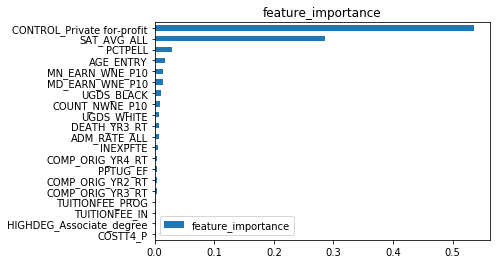

In [71]:
feature_importance_df =pd.DataFrame(data=model.feature_importances_,index=all_features,columns=["feature_importance"])
ax = feature_importance_df.sort_values("feature_importance",ascending=False).head(20).plot(kind='barh',title='feature_importance')
ax.invert_yaxis()

### Very interesting results as it is very compliant with our analysis in exploration
### SAT_AVG_ALL, PCTPELL, AGEENTRY are highly correlated with target output from exporation
### Now all features with 0 contribution will be dropped, 
### and as expected some 0 contribution features are highly correlated with SAT_AVG_ALL AND PCTPELL (from our exploration)
### so they dont contribute anything in the tree

In [28]:
# from xgboost import plot_tree
# from matplotlib.pylab import rcParams

# ##set up the parameters
# rcParams['figure.figsize'] = 80,50
# plot_tree(model)

In [29]:
# for i in range(len(all_features)):
#     print("{} {}".format(i , all_features[i] ))